# Analyzing Streetlight Presence and Crime in Boston

## Research Question

 - What is the relationship between crime rates and the presence of streetlights?
 - And what other factors might contribute to higher crime rates?
 
The goal of this project is to determine if streetlights deter crime in the city of Boston. This project was guided by a personal experience by a member of the group who was attacked at night in an unlit area, as well as prior resarch conducted by the [University of Chicago Crime Lab](urbanlabs.uchicago.edu/attachments/e95d751f7d91d0bcfeb209ddf6adcb4296868c12/store/cca92342e666b1ffb1c15be63b484e9b9687b57249dce44ad55ea92b1ec0/lights_04242016.pdf.) that determined that streetlights were a drime deterrent. This project will also investigate other possible features that may have an impact on crime in Boston, namely GINI coefficient, unemployment rate, poverty rate, and percent of population with a bachelor's degree. The results of the project will uncover areas within Boston that have high crime and determine the cause. With this, the city would be able to more easily take action to decrease the level of crimes within these areas. 


## Data Used
The goal of this notebook is to provide insights for the level of crime in a tract in Boston and the density of streetlights to see if there is, in fact, any correlation. This will be done by reading in the Shapes file of the tracts used in the 2010 US Census from [BARI](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/SQ6BT4). This data contains the geometries that will be overlayed on the crimes and streetlights as well as other features to determine if there is a correlation. The data of Crimes within Boston comes from [Boston.gov](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system). This dataset provides all crimes reported within the 2018 calendar year including the type of crime, location, and date and time.  Our streetlight data in Boston was collected from [Boston.gov](https://data.boston.gov/dataset/streetlight-locations), which contains all streetlight locations. Finally, to acquire tract-level data, we utilized [BARI](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/XZXAUP) for our Census data, which included GINI coefficient, unemployment rate, poverty rate, and percent of population with a bachelors degree.


## Methodology
1. Pull all of the data sourcesinto the notebook via Pandas.
2. Clean the data, looking for missing values and repeats.
3. Filter the crimes so only the ones that occur at night are kept.
4. Convert streetlight and crime locations to geometries with GeoPandas.
5. Sort streetlight and crimes by tract and count them to get tract level data. This constitutes the merging of datasets. This also will be done using GeoPandas.
6. Calculate densities of crime and streetlights.
7. Merge the dataset containing the tract level features into the tract data.
8. Run regressions.
9. Analyze data.
10. Draw conclusions.

### Imports

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
import pytz
from shapely.geometry import Point, Polygon
from tqdm import tqdm
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
import folium
from folium import Choropleth
from folium.plugins import HeatMap
import requests
import json

/Users/danagajewski/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Reading in Data

In [2]:
#reads in the Shapes file as a GeoDataFrame
df_tract = gpd.read_file('Tracts_Boston_2010_BARI/Tracts_Boston BARI.shp')

df_tract.set_index(['CT_ID_10'], inplace=True)

df_tract.head()

GEOID10  ALAND10  AWATER10  POP100   HU100 Type  Res  \
CT_ID_10                                                                
25025010405  25025010405   363702         0  5522.0   994.0    I  0.0   
25025010404  25025010404   136829         0  5817.0  1862.0    I  0.0   
25025010801  25025010801   127905         0  2783.0  1899.0    R  1.0   
25025010702  25025010702   299981         0  2400.0  1643.0    R  1.0   
25025010204  25025010204   254706         0  3173.0  1283.0    I  0.0   

             BRA_PD_ID                BRA_PD  City_Counc  WARD  \
CT_ID_10                                                         
25025010405          7        Fenway/Kenmore           7     4   
25025010404          7        Fenway/Kenmore           7     4   
25025010801          5  Back Bay/Beacon Hill           8     5   
25025010702          5  Back Bay/Beacon Hill           8     5   
25025010204          7        Fenway/Kenmore           8    21   

                   ISD_Nbhd  Police_Dis  Fire_Distr  \
CT_ID_10                                              
25025010405  Fenway/Kenmore           4           4   
25025010404  Fenway/Kenmore           4           4   
25025010801        Back Bay           4           4   
25025010702        Back Bay           4           4   
25025010204  Fenway/Kenmore           4           4   

                                            PWD  \
CT_ID_10                                          
25025010405  1-10A: Kenmore/Fenway/Mission Hill   
25025010404  1-10A: Kenmore/Fenway/Mission Hill   
25025010801   1-1C: Back Bay/South End/Downtown   
25025010702   1-1C: Back Bay/South End/Downtown   
25025010204  1-10A: Kenmore/Fenway/Mission Hill   

                                                      geometry  
CT_ID_10                                                        
25025010405  POLYGON ((-71.09009 42.34666, -71.09000 42.346...  
25025010404  POLYGON ((-71.09066 42.33977, -71.09103 42.339...  
25025010801  POLYGON ((-71.08159 42.35370, -71.08044 42.354...  
25025010702  POLYGON ((-71.07066 42.35185, -71.07045 42.351...  
25025010204  POLYGON ((-71.10683 42.34875, -71.10520 42.348...

In [3]:
#reads in the crime datasets
df_crime = pd.read_csv('crime-incident-reports-2018.csv')

df_crime.head()

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP OFFENSE_DESCRIPTION  \
0      I192077559          3115  Investigate Person  INVESTIGATE PERSON   
1      I192077332           619             Larceny  LARCENY ALL OTHERS   
2      I192076660          2629          Harassment          HARASSMENT   
3      I192075386          2629          Harassment          HARASSMENT   
4      I192075335          3208       Property Lost  PROPERTY - MISSING   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH  \
0       B3            468      NaN  2018-04-30 09:00:00  2018      4   
1      E18            496      NaN  2018-03-06 08:00:00  2018      3   
2       E5            662      NaN  2018-10-31 12:00:00  2018     10   
3       A1             96      NaN  2018-04-09 08:43:00  2018      4   
4       D4            132      NaN  2018-01-01 00:00:00  2018      1   

  DAY_OF_WEEK  HOUR    UCR_PART            STREET        Lat       Long  \
0      Monday     9  Part Three       HAZLETON ST  42.279971 -71.095534   
1     Tuesday     8    Part One     HYDE PARK AVE  42.269224 -71.120853   
2   Wednesday    12    Part Two       PRIMROSE ST  42.290765 -71.130211   
3      Monday     8    Part Two      ATLANTIC AVE  42.355264 -71.050988   
4      Monday     0  Part Three  COMMONWEALTH AVE  42.353522 -71.072838   

                      Location  
0  (42.27997063, -71.09553354)  
1  (42.26922388, -71.12085347)  
2  (42.29076521, -71.13021098)  
3  (42.35526402, -71.05098788)  
4  (42.35352153, -71.07283786)

In [4]:
#reads in the street light data set
df_light = gpd.read_file('streetlight-locations/geo_export_6d166c39-621f-4ca5-8fa9-6de277c48821.shp')
df_light.head()

type       long        lat  objectid                    geometry
0  LIGHT -71.076044  42.353159       1.0  POINT (-71.07604 42.35316)
1  LIGHT -71.075382  42.353348       2.0  POINT (-71.07538 42.35335)
2  LIGHT -71.074775  42.353521       3.0  POINT (-71.07477 42.35352)
3  LIGHT -71.074404  42.353556       4.0  POINT (-71.07440 42.35356)
4  LIGHT -71.073621  42.353811       5.0  POINT (-71.07362 42.35381)

## Getting Rid of Extraneous Data

Because our utilized dataframes all contain unnecessary data, they will be filtered to contain only the data pertinent for this analysis.


In [5]:
#only keeps the columns that of interest for tract dataframe
keep_cols = ['ALAND10', 'POP100', 'geometry']
df_tract = df_tract[keep_cols]

In [6]:
#only keeps the columns that of interest for crime dataframe
keep_cols = ['INCIDENT_NUMBER', 'OFFENSE_CODE_GROUP', 'OCCURRED_ON_DATE', 'Lat', 'Long']
df_crime = df_crime[keep_cols]

In [7]:
#only keeps the columns that of interest for crime dataframe
keep_cols = ['objectid', 'geometry', 'lat', 'long']
df_light = df_light[keep_cols]

## Cleaning the Datasets

This section handles the shape of the dataframes; if there are any repeats or if there are any missing values and the actions taken. 

### Looking for Missing Values

To ensure that the data is represented accurately, the datasets are all checked to ensure that they are not missing any values that are important to the analysis. 

In [8]:
#looks at the number of missing values in each column of the tract dataset
for col in df_tract.columns:
    print("Missing values for {}: ".format(col) + str(df_tract[col].isna().sum()))

Missing values for ALAND10: 0
Missing values for POP100: 0
Missing values for geometry: 0


In [9]:
#looks at the number of missing values in each column of the crime dataset
for col in df_crime.columns:
    print("Missing values for {}: ".format(col) + str(df_crime[col].isna().sum()))

Missing values for INCIDENT_NUMBER: 0
Missing values for OFFENSE_CODE_GROUP: 0
Missing values for OCCURRED_ON_DATE: 0
Missing values for Lat: 6429
Missing values for Long: 6429


There are crimes that are missing latitude and longitude. These will need to be removed because without a location, they are useless to this project. 

In [10]:
#looks at the number of missing values in each column of the light dataset
for col in df_light.columns:
    print("Missing values for {}: ".format(col) + str(df_light[col].isna().sum()))

Missing values for objectid: 0
Missing values for geometry: 0
Missing values for lat: 0
Missing values for long: 0


### Removing Missing Values

The only dataset that has missing values is the crime dataset which has missing data for the latitude and longitude. Because the analysis relies on the locations of all objects, they must be removed. Any crime that has a missing latitude or longitude will be completely removed from the dataset. 

In [11]:
#drops any crime where the latitude or longitude is missing
df_crime.dropna(subset=['Lat', 'Long'], inplace=True)

In [12]:
#check to make sure all missing values were removed
for col in df_crime.columns:
    print("Missing values for {}: ".format(col) + str(df_crime[col].isna().sum()))

Missing values for INCIDENT_NUMBER: 0
Missing values for OFFENSE_CODE_GROUP: 0
Missing values for OCCURRED_ON_DATE: 0
Missing values for Lat: 0
Missing values for Long: 0


### Looking for Repeats

Each dataset has an identifier for every datapoint. The below checks if there are repeated IDs to determine if there are repeated entries. 

In [13]:
#Checking to see if there are any repeats in the tracts dataset
print('There are {} repeats.'.format(len(df_tract.index.values) - len(np.unique(df_tract.index.values))))

There are 0 repeats.


There don't appear to be repeated tracts.

In [14]:
#Checking to see if there are any repeats in the streetlights
print('There are {} repeats.'.format(len(df_light['objectid']) - len(np.unique(df_light['objectid']))))

There are 0 repeats.


There also do not appear to be any repeated streetlights

In [15]:
#Checking to see if there are any repeats in the crime dataset
print('There are {} repeats.'.format(len(df_crime['INCIDENT_NUMBER']) - len(np.unique(df_crime['INCIDENT_NUMBER']))))

There are 11198 repeats.


There appear to be repeated crimes in the crime dataset.

### Removing Repeats

To remove the repeated crimes, the crimes will be sorted on the date of the crime and then it will keep the latest version of the crime. This will only make a difference if for some reason the crime is updated at a later date. Otherwise, the date the crime occurred will be the same for the repeated crimes. In this case, we will assume everything is the same and will take whichever last in order of time. 

The 'OCCURRED_ON_DATE' column is a string and will be converted to a datetime to allow for easy sorting of dates. 

In [16]:
#checking the type of the date
type(df_crime.iloc[0]['OCCURRED_ON_DATE'])

str

In [17]:
#the list of datetimes that will be appended
occur_datetime = []

#creates a new datetime for each crime that represents the date it occured
for index, row in df_crime.iterrows():
    date_str = row['OCCURRED_ON_DATE']
    date_dt = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    occur_datetime.append(date_dt)
    
#check to make sure the conversion worked
print(occur_datetime[:5])

[datetime.datetime(2018, 4, 30, 9, 0), datetime.datetime(2018, 3, 6, 8, 0), datetime.datetime(2018, 10, 31, 12, 0), datetime.datetime(2018, 4, 9, 8, 43), datetime.datetime(2018, 1, 1, 0, 0)]


In [18]:
#adds the scrape date to the dataframe
df_crime['Date Occurred'] = occur_datetime

In [19]:
#removes the duplicate listings so only the most recent listing is kept
df_crime.sort_values('Date Occurred', ascending=True, inplace=True)
df_crime = df_crime.drop_duplicates(subset=['INCIDENT_NUMBER'], keep='last')
df_crime.head()

INCIDENT_NUMBER          OFFENSE_CODE_GROUP     OCCURRED_ON_DATE  \
97813      I182000585                     Larceny  2018-01-01 00:00:00   
96565      I182002477          Investigate Person  2018-01-01 00:00:00   
94026      I182005214  Larceny From Motor Vehicle  2018-01-01 00:00:00   
434        I192005657                       Other  2018-01-01 00:00:00   
22         I192068538                       Fraud  2018-01-01 00:00:00   

             Lat       Long Date Occurred  
97813  42.355475 -71.060518    2018-01-01  
96565  42.379236 -71.057889    2018-01-01  
94026  42.353145 -71.077639    2018-01-01  
434    42.291093 -71.065945    2018-01-01  
22     42.349780 -71.134230    2018-01-01

### Removing Crimes That Do Not Occur at Night

Because the streetlights only are on during the night, we will filter out the crimes that occur during the day as they have no significance on our results. To do this, we will query the [Sunrise-Sunset](https://sunrise-sunset.org/api) API. For each day, this will give us the time of the sunrise and sunset.

In [20]:
def get_sunrise_sunset(lat, lng, date='Today'):
    ''' Gets the sunrise and sunset data from the API with the given arguments
    
    Args:
        lat (float): the latitude of the location queried
        lng (float): the longitude of the location queried
        date (str) : a string representation in the form YYYY-MM-DD, or Today for todays info. 
    Returns:
        sun_dict (dict) : a dictionary with the data returned from the API
    '''
    
    #builds the url to query 
    url = 'https://api.sunrise-sunset.org/json?' + 'lat={}&lng={}'.format(str(lat),str(lng)) + '&date={}'.format(date)
    
    #gets the data from API
    response = requests.get(url)
    
    #reads to a dictionary
    sun_dict = response.json()
    
    #adds the lat-lon and date
    sun_dict['lat-lng'] = (lat, lng)
    sun_dict['date'] = date
    
    return sun_dict

In [21]:
def change_tz(from_dt, timezone_from='UTC', timezone_to='UTC'):
    ''' changes a datetime object from one timezone to another
    
    Args:
        from_dt  (datetime): the datetime object that will be converted
        timezone_from (str): the string representation of the timezone converted from, default utc
        timezone_to   (str): the string representation of the timezone to be converted to, default utc
    Returns:
        out_dt (datetime) : the datetime object that has been converted to the new timezone. 
    '''
    #localizes the timezone
    zone_from = pytz.timezone(timezone_from)
    localized_dt = zone_from.localize(from_dt)
    
    #takes the localized timezone to the new timezone
    to_zone = pytz.timezone(timezone_to)
    out_dt = localized_dt.astimezone(to_zone)
    
    return out_dt

In [22]:
def clean_sun_dict(sun_dict, timezone_to='UTC'):
    ''' Cleans the data returned from the API call in get_sunrise_sunset
    
    args:
        sun_dict (dict): the dictionary produced by get_sunrise_sunset
        timezone_to (str): the string represenatation of the timezone the datetimes should be converted to
        
    returns:
        clean_dict (series): the cleaned and reformatted dictionary in a series
    
    '''
    
    #sets up the cleaned dictionary
    cleaned_dict = {}
    
    #adds the date in the form of a datetime
    cleaned_dict['date'] = datetime.strptime(sun_dict['date'], '%Y-%m-%d')
    
    #adds lat-lng
    cleaned_dict['lat-lng'] = sun_dict['lat-lng']
    
    #gets the datetime object for the sunrise
    dt_obj_sunrise = datetime.strptime(sun_dict['results']['sunrise'], '%I:%M:%S %p')
    
    #combines datetime objects
    combined_dt_sr = datetime.combine(cleaned_dict['date'], dt_obj_sunrise.time())
    
    #adds sunrise as a time object
    cleaned_dict['sunrise'] = change_tz(combined_dt_sr, timezone_to=timezone_to).time()
    
    #adds sunrise as a float representation
    cleaned_dict['sunrise_hr'] = cleaned_dict['sunrise'].hour + (cleaned_dict['sunrise'].minute/60.0) 
    + (cleaned_dict['sunrise'].second/3600.0)
    
    #gets the datetime object for the sunset
    dt_obj_sunset = datetime.strptime(sun_dict['results']['sunset'], '%I:%M:%S %p')
    
    #combines datetime objects
    combined_dt_ss = datetime.combine(cleaned_dict['date'], dt_obj_sunset.time())
    
    #adds sunset as a time object
    cleaned_dict['sunset'] = change_tz(combined_dt_ss, timezone_to=timezone_to).time()
    
    #adds sunset as a float representation
    cleaned_dict['sunset_hr'] = cleaned_dict['sunset'].hour + (cleaned_dict['sunset'].minute/60.0) 
    + (cleaned_dict['sunset'].second/3600.0)
    
    return pd.Series(cleaned_dict)

In [23]:
def get_annual_sun_data(loc_dict, year=2021, period_day=30):
    ''' Gets the data for a given year with the same data offset by the period_day for a list of cities
    
    Args:
        loc_dict  (dict): a dictionary that contains city names as keys, with the value being a tuple with
                          lat, lng, and timezone.
        year       (int): the year which the data is being collected for
        period_day (int): the period offset
        
    returns:
        df_out (DataFrame): the output dataframe from combinding the data for the cities. 
    
    '''
    
    #sets up the dataframe
    dict_out = {'city' : [], 'date' : [], 'day of year' : [], 'lat-lng' : [],
                'sunrise' : [], 'sunrise_hr' : [], 'sunset' : [], 'sunset_hr' : []}
    
    #start date
    start_time = datetime(year=year, month=1, day=1)
    
    #gets sun data from start of year
    for city in loc_dict:
        
        #gets data and cleans it
        data = get_sunrise_sunset(loc_dict[city][0], loc_dict[city][1], date=start_time.strftime('%Y-%m-%d'))
        cleaned_data = clean_sun_dict(data, loc_dict[city][2])
        
        #adds to the out_dict
        dict_out['city'].append(city)
        dict_out['date'].append(start_time)
        dict_out['day of year'].append(1.0)
        dict_out['lat-lng'].append(cleaned_data['lat-lng'])
        dict_out['sunrise'].append(cleaned_data['sunrise'])
        dict_out['sunrise_hr'].append(cleaned_data['sunrise_hr'])
        dict_out['sunset'].append(cleaned_data['sunset'])
        dict_out['sunset_hr'].append(cleaned_data['sunset_hr'])
        
    #finds sun data for an entire year with the given period
    total_days = 0
    while (total_days + period_day <= 365):
    
        #finds the end of the period
        a_timedelta = timedelta(days=total_days+period_day)
        end_time = datetime(year=year, month=1, day=1) + a_timedelta

        #gets sun data from start of year
        for city in loc_dict:

            #gets data and cleans it
            data = get_sunrise_sunset(loc_dict[city][0], loc_dict[city][1], date=end_time.strftime('%Y-%m-%d'))
            cleaned_data = clean_sun_dict(data, loc_dict[city][2])

            #adds to the out_dict
            dict_out['city'].append(city)
            dict_out['date'].append(end_time)
            dict_out['day of year'].append(total_days + period_day)
            dict_out['lat-lng'].append(cleaned_data['lat-lng'])
            dict_out['sunrise'].append(cleaned_data['sunrise'])
            dict_out['sunrise_hr'].append(cleaned_data['sunrise_hr'])
            dict_out['sunset'].append(cleaned_data['sunset'])
            dict_out['sunset_hr'].append(cleaned_data['sunset_hr'])
        
        #increases accumulator
        total_days += period_day
    
    return pd.DataFrame(dict_out)

In [24]:
# the location and timezone of boston
loc_dict = {'Boston': (42.3601, -71.0589, 'US/Eastern')}

#gets the annual sun data of boston in 2018 to compare to our crimes. 
df_annual_sun = get_annual_sun_data(loc_dict, year=2018, period_day=1)

In [25]:
df_annual_sun.head()

city       date  day of year              lat-lng   sunrise  sunrise_hr  \
0  Boston 2018-01-01          1.0  (42.3601, -71.0589)  07:13:24    7.216667   
1  Boston 2018-01-02          1.0  (42.3601, -71.0589)  07:13:27    7.216667   
2  Boston 2018-01-03          2.0  (42.3601, -71.0589)  07:13:26    7.216667   
3  Boston 2018-01-04          3.0  (42.3601, -71.0589)  07:13:24    7.216667   
4  Boston 2018-01-05          4.0  (42.3601, -71.0589)  07:13:19    7.216667   

     sunset  sunset_hr  
0  16:22:49  16.366667  
1  16:23:43  16.383333  
2  16:24:38  16.400000  
3  16:25:35  16.416667  
4  16:26:33  16.433333

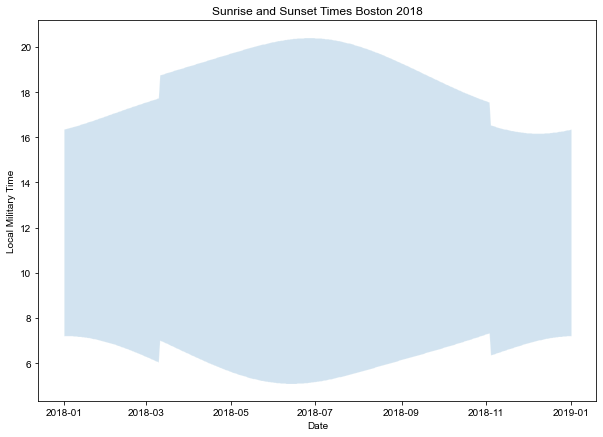

In [26]:
#plot the sunset and sunrise times to make sure they make sense
plt.fill_between(x=df_annual_sun['date'], y2=df_annual_sun['sunset_hr'],
                     y1=df_annual_sun['sunrise_hr'], alpha=.2)
    
#formats the plot
plt.title("Sunrise and Sunset Times Boston 2018")
plt.xlabel('Date')
plt.ylabel('Local Military Time')
plt.gcf().set_size_inches(10, 7)    
sns.set()

In the figure above, the colored area represents daytime. 

In [27]:
#stores indices to be dropped
to_drop = []

#filters the crimes so that only the ones that occur after sunset and before sunrise are kept
for index, row in tqdm(df_crime.iterrows()):
    if ((datetime.strptime(row['OCCURRED_ON_DATE'], "%Y-%m-%d %H:%M:%S").time() <= df_annual_sun.loc[df_annual_sun['date'].apply(lambda x: x.date())  == row['Date Occurred'].date()].iloc[0]['sunset']) 
        & (datetime.strptime(row['OCCURRED_ON_DATE'], "%Y-%m-%d %H:%M:%S").time() >= df_annual_sun.loc[df_annual_sun['date'].apply(lambda x: x.date())  == row['Date Occurred'].date()].iloc[0]['sunrise'])):
        to_drop.append(index)

81261it [04:41, 288.56it/s]


In [28]:
#drops the crimes committed during the day
df_crime.drop(to_drop, inplace=True)

In [29]:
df_crime.shape

(30891, 6)

### Adding Geometry to Crime Dataset

The benefit of using a GeoDataFrame is that there are built in methods to the geometry that determine if one geometry is within another. To perform the analysis, a list of tracts with the number of street lights, number of crimes, and area are needed. To determine if a crime is within a tract, the latitude and longitude will need to be converted to a point geometry. This can be done with GeoPandas functions.

In [30]:
#creating a GeoDataFrame from the crime dataset
df_crime_geo = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime.Long, df_crime.Lat))
df_crime_geo.head()

INCIDENT_NUMBER          OFFENSE_CODE_GROUP     OCCURRED_ON_DATE  \
97813      I182000585                     Larceny  2018-01-01 00:00:00   
96565      I182002477          Investigate Person  2018-01-01 00:00:00   
94026      I182005214  Larceny From Motor Vehicle  2018-01-01 00:00:00   
434        I192005657                       Other  2018-01-01 00:00:00   
22         I192068538                       Fraud  2018-01-01 00:00:00   

             Lat       Long Date Occurred                    geometry  
97813  42.355475 -71.060518    2018-01-01  POINT (-71.06052 42.35548)  
96565  42.379236 -71.057889    2018-01-01  POINT (-71.05789 42.37924)  
94026  42.353145 -71.077639    2018-01-01  POINT (-71.07764 42.35315)  
434    42.291093 -71.065945    2018-01-01  POINT (-71.06595 42.29109)  
22     42.349780 -71.134230    2018-01-01  POINT (-71.13423 42.34978)

## Visualizing the GeoData

One of the great things about GeoPandas and geometry is that it allows a map to be generated from the data. It is a good way to make sure the data is being pulled in properly.

In [31]:
#gives each tract its own number to clearly show colors between tracts
df_tract['num_id'] = range(0,178)

# Create a base map
m_1 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=12)

# Add a choropleth map to the base map
Choropleth(geo_data=df_tract.__geo_interface__, 
           data=df_tract['num_id'],
           key_on="feature.id",
           fill_color='YlGnBu',
           legend_name='Plot Tracts in Boston 2010 Census').add_to(m_1)
m_1.save('2010_tract_map.html')
m_1

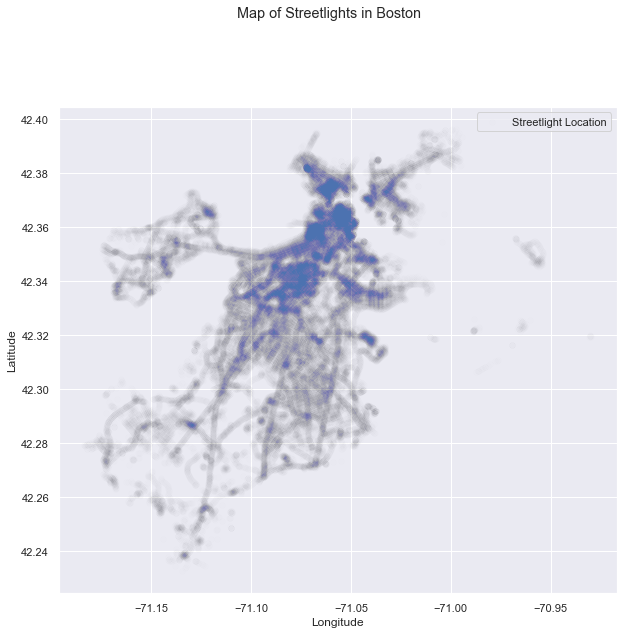

In [32]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = df_light.plot(color='b', ax=ax, alpha = .005, label='Streetlight Location')

#formats the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle("Map of Streetlights in Boston")
plt.legend()
sns.set(font_scale=1.3)
plt.show()


In [33]:
# Create a base map
m_2 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=12)

# Add a heatmap to the base map
HeatMap(data=df_light[['lat', 'long']], radius=10).add_to(m_2)

#save the map
m_2.save('streetlight_heatmap.html')

#display the map
m_2

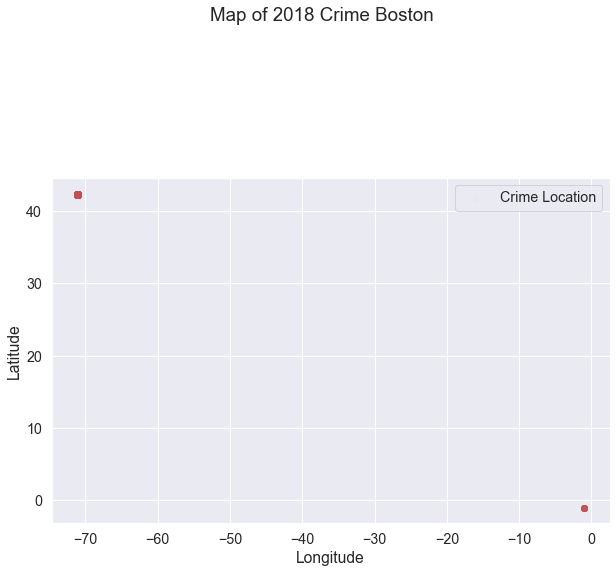

In [34]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = df_crime_geo.plot(color='r', ax=ax, alpha=.01, label='Crime Location')

#formats the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle("Map of 2018 Crime Boston")
plt.legend()
plt.show()

### Filtering Crime Geometries

Per above, it appears that some of the crimes were reported to have occurred far from Boston (it seems they were near the coast of Africa at 0'N -1'E on Null Island). These will have to be filtered out so that only the crimes reported in Boston remain. 

In [35]:
#filtering out crimes that did not occur in Boston. 
df_crime = df_crime[(df_crime['Lat'] < 43) & (df_crime['Long'] > -72) &
                    (df_crime['Lat'] > 41) & (df_crime['Long'] < -70)]

#creating a GeoDataFrame from the crime dataset
df_crime_geo = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime.Long, df_crime.Lat))
df_crime_geo.head()

INCIDENT_NUMBER          OFFENSE_CODE_GROUP     OCCURRED_ON_DATE  \
97813      I182000585                     Larceny  2018-01-01 00:00:00   
96565      I182002477          Investigate Person  2018-01-01 00:00:00   
94026      I182005214  Larceny From Motor Vehicle  2018-01-01 00:00:00   
434        I192005657                       Other  2018-01-01 00:00:00   
22         I192068538                       Fraud  2018-01-01 00:00:00   

             Lat       Long Date Occurred                    geometry  
97813  42.355475 -71.060518    2018-01-01  POINT (-71.06052 42.35548)  
96565  42.379236 -71.057889    2018-01-01  POINT (-71.05789 42.37924)  
94026  42.353145 -71.077639    2018-01-01  POINT (-71.07764 42.35315)  
434    42.291093 -71.065945    2018-01-01  POINT (-71.06595 42.29109)  
22     42.349780 -71.134230    2018-01-01  POINT (-71.13423 42.34978)

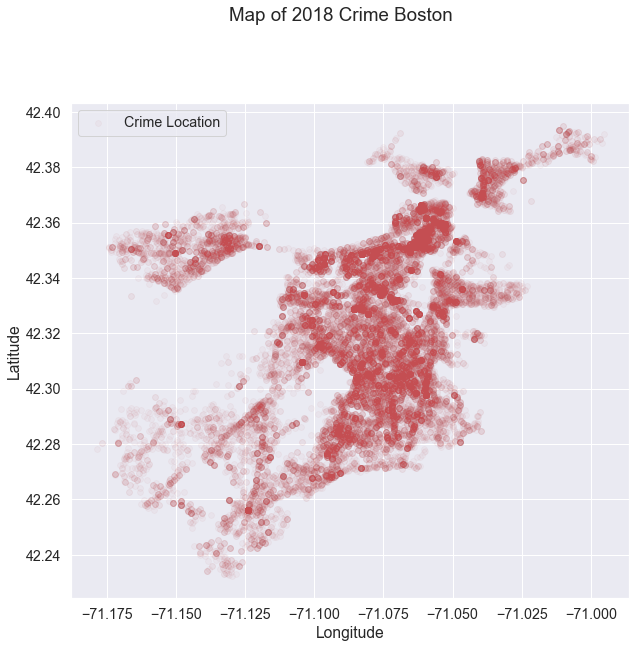

In [36]:
fig, ax = plt.subplots(1, figsize=(10,10))
ax = df_crime_geo.plot(color='r', ax=ax, alpha = .04, label='Crime Location')

#formats the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle("Map of 2018 Crime Boston")
sns.set(font_scale=1.3)
plt.legend()
plt.show()

In [37]:
# Create a base map
m_3 = folium.Map(location=[42.32,-71.0589], tiles='cartodbpositron', zoom_start=12)

# Add a heatmap to the base map
HeatMap(data=df_crime[['Lat', 'Long']], radius=10).add_to(m_3)

#save the map
m_3.save('crime_heatmap.html')

#display the map
m_3

### Generating Tract Level Counts

To perform an analysis based on the number of crimes and lightpoles in a tract, counts for each tract must be performed. Unfortunately, the simplest (not the most efficient) way to perform this is to loop through all of points and tracts and check if a point is in a tract, and increase said tract's count by 1 if it is. 

This constitutes merging the datasets in a slightly more complicated manner. 

In [38]:
def get_counts(df_counts, df_tract):
    ''' Gets the number of points in the counts dataframe in each tract in the tract dataframe
    
    Args:
        df_counts (gpd.GeoDataFrame): The dataframe containing the point geometry within one of the tracts
        df_tract  (gpd.GeoDataFrame): The dataframe containing the tract shapes and ids
        
    Returns:
        counts    (dict): a dictionary with all tracts and the number of points within them
    '''
    
    #sets up dictionary to put the counts into
    counts = {}
    
    #initializing the counts dictionary so all tract counts start at 0
    for idx, row in df_tract.iterrows():
        counts[row['CT_ID_10']] = 0
    
    #adds the number of crimes in each tract
    for idx, row in tqdm(df_counts.iterrows()):
        point = row['geometry']
        for index, tract in df_tract.iterrows():
            if point.within(tract['geometry']):
                counts[tract['CT_ID_10']] += 1
            else:
                pass
            
    #check that the counts were correctly added
    counts_sum = 0
    for key in counts.keys():
        counts_sum += counts[key]
        
    print('Number of points outside tracts: ' + str(df_counts.shape[0] - counts_sum))
    return counts

#### NOTE: If commenting out, comment from here to next note. 

#### Crime Counts

In [39]:
df_tract.reset_index(inplace=True)

#gets the counts of crimes per tract (takes about 6 mins to run)
crime_counts = get_counts(df_crime_geo, df_tract)

30778it [06:42, 76.53it/s]

Number of points outside tracts: 20


It appears that 40 of the crimes were reported to be outside of the tract locations. This is a small enough proportion of the sample size that it can be ignored. 

#### Streetlight Counts

In [40]:
#gets the counts of lights per tract (takes about 15 minutes to run)
light_counts = get_counts(df_light, df_tract)

74065it [16:15, 75.94it/s]

Number of points outside tracts: 1274


There are 1274 streetlights outside of all tracts. While no longer negligible, there is not much that can be done as they are outside the tracts. We will assume that the samples missing are randomly outside and there is not pattern, as there is nothing else that can be done. 

### Merging DataFrames

Now that there is data for number of streetlights and crimes for the tracts in dictionaries, these can be turned into dataframes and appended to the df_tracts to begin the analysis on streetlights and crime.

In [41]:
#create dataframes for each crime and light counts
df_counts_crime = pd.DataFrame(crime_counts, index=[0])
df_counts_light = pd.DataFrame(light_counts, index=[0])

#rotate the dataframes so they may be merged with the tract dataframe
df_counts_crime = df_counts_crime.transpose()
df_counts_light = df_counts_light.transpose()

#adds the name of columns to distinguish streelights and crime
df_counts_crime.columns = ['Crimes']
df_counts_light.columns = ['Streetlights']

In [42]:
#merge the crime and light counts
df_counts = df_counts_crime.merge(df_counts_light, how='left', left_index=True, right_index=True)

df_tract.set_index('CT_ID_10', inplace=True)

#merge the tract dataframe with the counts dataframe
df_tract = df_tract.merge(df_counts, how='left', left_index=True, right_index=True)

df_tract.head()

ALAND10  POP100  \
CT_ID_10                       
25025010405   363702  5522.0   
25025010404   136829  5817.0   
25025010801   127905  2783.0   
25025010702   299981  2400.0   
25025010204   254706  3173.0   

                                                      geometry  num_id  \
CT_ID_10                                                                 
25025010405  POLYGON ((-71.09009 42.34666, -71.09000 42.346...       0   
25025010404  POLYGON ((-71.09066 42.33977, -71.09103 42.339...       1   
25025010801  POLYGON ((-71.08159 42.35370, -71.08044 42.354...       2   
25025010702  POLYGON ((-71.07066 42.35185, -71.07045 42.351...       3   
25025010204  POLYGON ((-71.10683 42.34875, -71.10520 42.348...       4   

             Crimes  Streetlights  
CT_ID_10                           
25025010405      95           482  
25025010404      55           206  
25025010801      59           162  
25025010702     260           569  
25025010204      95           207

In [43]:
df_tract.to_file('2010_tract_counts.shp')

/Users/danagajewski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  """Entry point for launching an IPython kernel.


#### NOTE: To save run time, it is suggested to comment the above out an read in the file below. 

In [44]:
#read in tract data
df_tract = gpd.read_file('2010_tract_counts.shp')
df_tract = df_tract.rename(columns={'Streetligh' : 'Streetlights'})
df_tract.head()

CT_ID_10  ALAND10  POP100  num_id  Crimes  Streetlights  \
0  25025010405   363702  5522.0       0      95           482   
1  25025010404   136829  5817.0       1      55           206   
2  25025010801   127905  2783.0       2      59           162   
3  25025010702   299981  2400.0       3     260           569   
4  25025010204   254706  3173.0       4      95           207   

                                            geometry  
0  POLYGON ((-71.09009 42.34666, -71.09000 42.346...  
1  POLYGON ((-71.09066 42.33977, -71.09103 42.339...  
2  POLYGON ((-71.08159 42.35370, -71.08044 42.354...  
3  POLYGON ((-71.07066 42.35185, -71.07045 42.351...  
4  POLYGON ((-71.10683 42.34875, -71.10520 42.348...

### Ensuring Data Validity

Checking the newly appended columns to ensure that there is no missing data. 

In [45]:
#looks at the number of missing streetlight counts and  in each tract
for col in ['Crimes', 'Streetlights']:
    print("Missing values for {}: ".format(col) + str(df_tract[col].isna().sum()))

Missing values for Crimes: 0
Missing values for Streetlights: 0


## Visualizing Crime and Streetlight Concentration

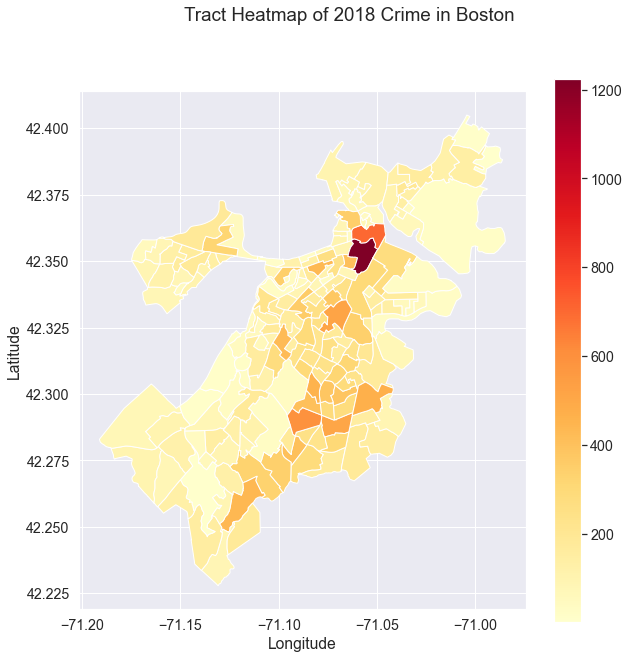

In [46]:
#generates the heatmap
fig, ax = plt.subplots(1, figsize=(10,10))
ax = df_tract.plot(column = df_tract['Crimes'], ax=ax, legend=True, cmap='YlOrRd')


#formats the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle("Tract Heatmap of 2018 Crime in Boston")
sns.set(font_scale=1.3)
plt.show()



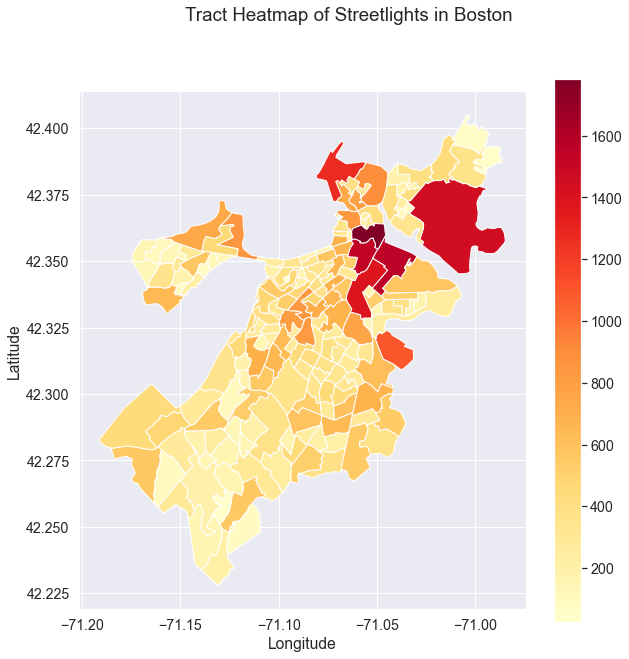

In [47]:
#generates the heatmap
fig, ax = plt.subplots(1, figsize=(10,10))
ax = df_tract.plot(column = df_tract['Streetlights'], ax=ax, legend=True, cmap='YlOrRd')

#formats the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle("Tract Heatmap of Streetlights in Boston")
sns.set(font_scale=1.3)
plt.show()

### Calculating Density

From looking at the above graphs, there is no clear pattern between the concentration of streetlights and crime. There appears to be a possible correlation where the number of crimes and streetlights are both higher near the North End. There is, however, more streetlights near Boston Logan Airport and fewer crimes. To make any conclusion, a regression analysis will need to be run. 

There is one final issue to be addressed. These counts are not yet normalized for are of the tracts, so the number of streetlights and crimes will be divided by area to get a true concentration.

In [48]:
#stores densities
light_density = []
crime_density = []
pop_density = []

#calculates densities
for idx, row in df_tract.iterrows():
    light_density.append(row['Streetlights'] / row['ALAND10'])
    crime_density.append(row['Crimes'] / row['ALAND10'])
    pop_density.append(row['POP100'] / row['ALAND10'])

In [49]:
#append the new columns to the dataframe
df_tract['Streetlight Density'] = light_density
df_tract['Crime Density'] = crime_density
df_tract['POP100 Density'] = pop_density

## Visualizing Densities

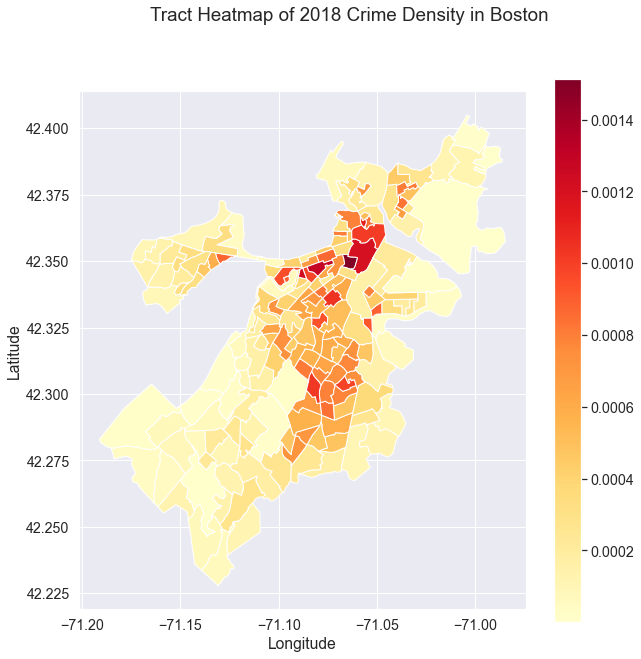

In [50]:
#generates the heatmap
fig, ax = plt.subplots(1, figsize=(10,10))
ax = df_tract.plot(column = 'Crime Density', ax=ax, legend=True, cmap='YlOrRd')

#formats the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle("Tract Heatmap of 2018 Crime Density in Boston")
sns.set(font_scale=1.3)
plt.show()

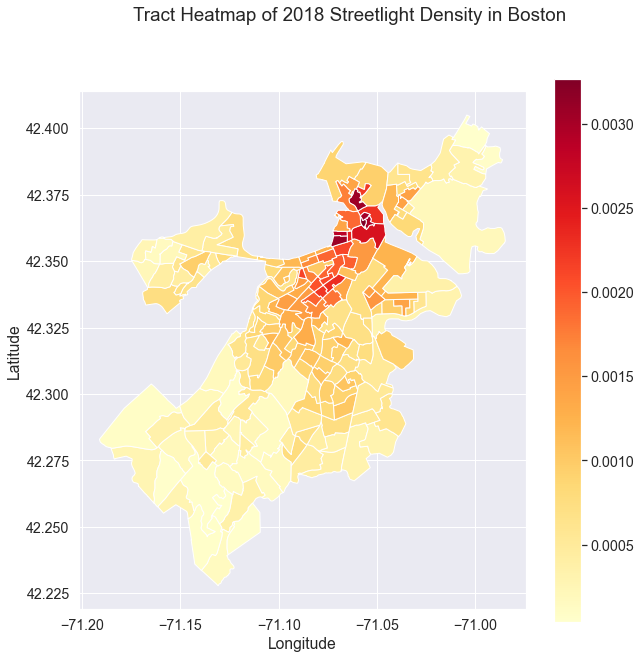

In [51]:
#generates the heatmap
fig, ax = plt.subplots(1, figsize=(10,10))
ax = df_tract.plot(column = 'Streetlight Density', ax=ax, legend=True, cmap='YlOrRd')

#formats the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.suptitle("Tract Heatmap of 2018 Streetlight Density in Boston")
sns.set(font_scale=1.3)
plt.show()

Now that we are looking at density of the crimes and streetlights, there are more solid conclusions that can be drawn.

## Analysis

In determining the number of crimes in an area, all crimes will be included because the goal of the project is to help people avoid areas of high crime. Any type of crime is undesireable and thus all are included. 

In [52]:
def train_regressor(regression_data, x_feats, y_feat):
    """ trains a model that predicts the given y feature from the list of x features

    Args:
        regression_data (DataFrame): the data to be used for regression
        x_feats       (list): list of x features to be regressed to predict y feature
        y_feat        (str): the y feature that is being predicted
        
    Returns:
        reg (LinearRegression): the regression model after it has been trained
    """
    
    n_splits = 10
    
    # get target variable
    x = regression_data.loc[:, x_feats].values
    y_true = regression_data.loc[:, y_feat].values

    # initialize a Linear Regression model
    reg = LinearRegression()

    # initialize the kfolds
    kfold = KFold(n_splits=n_splits)

    # initialize an empty array same size as y_true
    y_hat = np.empty_like(y_true)
    
    # train on training data
    reg.fit(x, y_true)

    # estimate each rows class
    y_hat = reg.predict(x)  

    #NOTE: The below is for cross validation, however overfitting is a non-issue as this is a linear regression
    #because of this, it is skipped. Uncommenting will perform a cross-validated regression
    
    #for train_idx, test_idx in kfold.split(x, y_true):

        # get training data
        #x_train = x[train_idx]
        #y_true_train = y_true[train_idx]

        # get testing data
        #x_test = x[test_idx]
        #y_true_test = y_true[test_idx]

        # train on training data
        #reg.fit(x_train, y_true_train)

        # estimate each rows class
        #y_hat[test_idx] = reg.predict(x_test)  
    
    # print model   
    model_str = y_feat + f' = {reg.intercept_:.5f}'
    for feat, coef in zip(x_feats, reg.coef_):
        model_str += f' + {coef:.5f} {feat}'
        
    print(model_str)
        
    # compute r2
    r2 = r2_score(y_true=y_true, y_pred=y_hat)
    print('R^2: ' + str(r2))
    
    return reg, y_hat

In [53]:
def plot_regression_data(regression_data, x_feat, y_feat, reg):
    ''' Plots the data of a single feature linear regression model
    
    Args:
        regression_data (DataFrame): the data being regressed
        x_feat               (str): the x feature to be plotted
        y_feat               (str): the y feature that is being predicted
        reg      (LinearRegrssion): the list of predicted y features from the regression
    '''
    
    #gets the x features for scattering
    x = regression_data.loc[:, x_feat].values
    y_true = regression_data.loc[:, y_feat].values
    
    #predicting paired observatiosn for plotting purposes
    x_plot = np.linspace(x.min(), x.max(), 101).reshape(-1,1)
    y_plot = reg.predict(x_plot)
   
    #scatters the data
    plt.scatter(x, y_true, color='b', label='Actual data')
    
    #plots the model
    plt.plot(x_plot, y_plot, color='r', linewidth=4, label='Prediction')
    
    r2 = r2_score(y_true=y_true, y_pred=y_hat)
    
    #formats the graphs
    plt.legend()
    plt.xlabel(x_feat)
    plt.ylabel(y_feat)
    plt.suptitle('Regression of {} vs {} R^2: {:.4f}'.format(x_feat, y_feat, r2))
    plt.gcf().set_size_inches(10, 10)
    
    #saves the graphs
    #plt.savefig(f"{ticker}_wsb_model_scatter.pdf")

In [54]:
#regress streetlight density on crime density
reg, y_hat = train_regressor(df_tract, ['Streetlight Density'], 'Crime Density')

Crime Density = 0.00018 + 0.24740 Streetlight Density
R^2: 0.29063192606906585


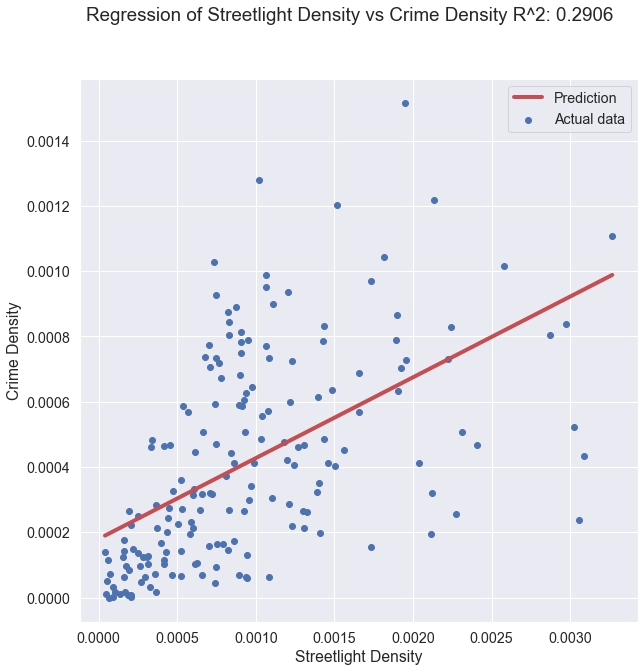

In [55]:
#plot the regression
plot_regression_data(df_tract, 'Streetlight Density', 'Crime Density', reg)

In [56]:
#train a regression with Streetlight Density and POP100 Density
reg, y_hat = train_regressor(df_tract, ['Streetlight Density', 'POP100 Density'], 'Crime Density')

Crime Density = 0.00012 + 0.15386 Streetlight Density + 0.01606 POP100 Density
R^2: 0.3695254041263428


### Pulling In More Data

In [57]:
df_tract_dem = pd.read_csv('ACS_1418_TRACT.csv')
df_tract_dem.set_index('CT_ID_10', inplace=True)
df_tract_dem.head()

NAME  TotalPop  \
CT_ID_10                                                                   
25025060501  Census Tract 605.01, Suffolk County, Massachus...      4071   
25025061101  Census Tract 611.01, Suffolk County, Massachus...      2300   
25025070101  Census Tract 701.01, Suffolk County, Massachus...      7075   
25025070402  Census Tract 704.02, Suffolk County, Massachus...      2398   
25025071101  Census Tract 711.01, Suffolk County, Massachus...      4290   

                   PopDen  SexRatio    AgeU18   Age1834   Age3564    AgeO65  \
CT_ID_10                                                                      
25025060501  25608.002098  0.873447  0.116925  0.500614  0.334316  0.048145   
25025061101  36041.432219  1.516411  0.326522  0.278261  0.320000  0.075217   
25025070101  17451.799633  1.001981  0.075760  0.473357  0.335124  0.115760   
25025070402  23277.190615  1.072602  0.095913  0.372811  0.337364  0.193912   
25025071101  31070.961175  1.047733  0.113986  0.359207  0.413753  0.113054   

              ForBorn     White  ...  MedYrBuiltRaw    MedYrBuilt  \
CT_ID_10                         ...                                
25025060501  0.066323  0.913780  ...            0.0           NaN   
25025061101  0.282609  0.177391  ...            0.0           NaN   
25025070101  0.371166  0.525230  ...         2001.0  2000 to 2009   
25025070402  0.472060  0.298165  ...         1992.0  1990 to 1999   
25025071101  0.316550  0.478322  ...            0.0           NaN   

             MedYrMovedIn  MedYrRentMovedIn  AREA_ACRES  TOWN_ID    TOWN  \
CT_ID_10                                                                   
25025060501        2012.0            2013.0    101.7369     35.0  BOSTON   
25025061101        2008.0            2008.0     40.8386     35.0  BOSTON   
25025070101        2013.0            2014.0    251.8164     35.0  BOSTON   
25025070402        2012.0            2012.0     66.1367     35.0  BOSTON   
25025071101        2013.0            2014.0     89.6364     35.0  BOSTON   

             FIPS_STCO   COUNTY  MAtown  
CT_ID_10                                 
25025060501    25025.0  SUFFOLK  BOSTON  
25025061101    25025.0  SUFFOLK  BOSTON  
25025070101    25025.0  SUFFOLK  BOSTON  
25025070402    25025.0  SUFFOLK  BOSTON  
25025071101    25025.0  SUFFOLK  BOSTON  

[5 rows x 57 columns]

In [58]:
#change tract id from string to int to be able to compare with df_tract_dem
df_tract['CT_ID_10'] = df_tract['CT_ID_10'].apply(lambda x: int(x))

#set index to be the tract id
df_tract.set_index('CT_ID_10', inplace=True)

#merge the dataframes
df_merged = df_tract.merge(df_tract_dem, how='left', left_index=True, right_index=True)

In [59]:
df_merged.columns.values

array(['ALAND10', 'POP100', 'num_id', 'Crimes', 'Streetlights',
       'geometry', 'Streetlight Density', 'Crime Density',
       'POP100 Density', 'NAME', 'TotalPop', 'PopDen', 'SexRatio',
       'AgeU18', 'Age1834', 'Age3564', 'AgeO65', 'ForBorn', 'White',
       'Black', 'Asian', 'Hispanic', 'TwoOrMore', 'EthHet',
       'MedHouseIncome', 'PubAssist', 'GINI', 'FamPovPer', 'UnempRate',
       'TotalHouseH', 'FamHousePer', 'FemHeadPer', 'SameSexCoupPer',
       'GrandHeadPer', 'LessThanHS', 'HSGrad', 'SomeColl', 'Bach',
       'Master', 'Prof', 'Doc', 'CommuteLess10', 'Commute1030',
       'Commute3060', 'Commute6090', 'CommuteOver90', 'ByAuto',
       'ByPubTrans', 'ByBike', 'ByWalk', 'TotalHouseUnits',
       'VacantUnitPer', 'RentersPer', 'HomeOwnPer', 'MedGrossRent',
       'MedHomeVal', 'MedYrBuiltRaw', 'MedYrBuilt', 'MedYrMovedIn',
       'MedYrRentMovedIn', 'AREA_ACRES', 'TOWN_ID', 'TOWN', 'FIPS_STCO',
       'COUNTY', 'MAtown'], dtype=object)

In [60]:
#only keeps the columns that of interest for tract dataframe
keep_cols = ['ALAND10', 'POP100', 'geometry', 'Streetlights', 'Crimes', 'Streetlight Density', 'Crime Density',
            'POP100 Density', 'GINI', 'FamPovPer', 'UnempRate', 'Bach']

#drops columns not wanted
df_merged = df_merged[keep_cols]

df_merged.head()

ALAND10  POP100  \
CT_ID_10                       
25025010405   363702  5522.0   
25025010404   136829  5817.0   
25025010801   127905  2783.0   
25025010702   299981  2400.0   
25025010204   254706  3173.0   

                                                      geometry  Streetlights  \
CT_ID_10                                                                       
25025010405  POLYGON ((-71.09009 42.34666, -71.09000 42.346...           482   
25025010404  POLYGON ((-71.09066 42.33977, -71.09103 42.339...           206   
25025010801  POLYGON ((-71.08159 42.35370, -71.08044 42.354...           162   
25025010702  POLYGON ((-71.07066 42.35185, -71.07045 42.351...           569   
25025010204  POLYGON ((-71.10683 42.34875, -71.10520 42.348...           207   

             Crimes  Streetlight Density  Crime Density  POP100 Density  \
CT_ID_10                                                                  
25025010405      95             0.001325       0.000261        0.015183   
25025010404      55             0.001506       0.000402        0.042513   
25025010801      59             0.001267       0.000461        0.021758   
25025010702     260             0.001897       0.000867        0.008001   
25025010204      95             0.000813       0.000373        0.012458   

               GINI  FamPovPer  UnempRate      Bach  
CT_ID_10                                             
25025010405  0.5667   0.358025   0.224090  0.299191  
25025010404  0.5719   0.397059   0.174847  0.312447  
25025010801  0.5903   0.000000   0.054894  0.347788  
25025010702  0.5745   0.000000   0.041015  0.461330  
25025010204  0.5443   0.126437   0.089010  0.385795

In [61]:
#looks at the number of missing values in each column of the crime dataset
for col in df_merged.columns:
    print("Missing values for {}: ".format(col) + str(df_merged[col].isna().sum()))

Missing values for ALAND10: 0
Missing values for POP100: 0
Missing values for geometry: 0
Missing values for Streetlights: 0
Missing values for Crimes: 0
Missing values for Streetlight Density: 0
Missing values for Crime Density: 0
Missing values for POP100 Density: 0
Missing values for GINI: 8
Missing values for FamPovPer: 8
Missing values for UnempRate: 6
Missing values for Bach: 6


Interestingly, these areas with missing data are actually parks in Boston.

#### Removing Missing Data


In [62]:
#drops any tract where the GINI is missing
df_merged.dropna(subset=['GINI'], inplace=True)

In [63]:
#looks at the number of missing values in each column of the merged dataset
for col in df_merged.columns:
    print("Missing values for {}: ".format(col) + str(df_merged[col].isna().sum()))

Missing values for ALAND10: 0
Missing values for POP100: 0
Missing values for geometry: 0
Missing values for Streetlights: 0
Missing values for Crimes: 0
Missing values for Streetlight Density: 0
Missing values for Crime Density: 0
Missing values for POP100 Density: 0
Missing values for GINI: 0
Missing values for FamPovPer: 0
Missing values for UnempRate: 0
Missing values for Bach: 0


In [64]:
#regress population density on crime density
reg, y_hat = train_regressor(df_tract, ['POP100 Density'], 'Crime Density')

Crime Density = 0.00019 + 0.02517 POP100 Density
R^2: 0.2958931241090641


In [65]:
#regress gini coefficient on crime density
reg, y_hat = train_regressor(df_merged, ['GINI'], 'Crime Density')

Crime Density = -0.00048 + 0.00187 GINI
R^2: 0.19932720859258912


In [66]:
#regress poverty rate on crime density
reg, y_hat = train_regressor(df_merged, ['FamPovPer'], 'Crime Density')

Crime Density = 0.00033 + 0.00072 FamPovPer
R^2: 0.08410842843538469


In [67]:
#regress unemployment rate on crime density
reg, y_hat = train_regressor(df_merged, ['UnempRate'], 'Crime Density')

Crime Density = 0.00035 + 0.00106 UnempRate
R^2: 0.035412005935635094


In [68]:
#regress % pop with bachelors degree on crime density
reg, y_hat = train_regressor(df_merged, ['Bach'], 'Crime Density')

Crime Density = 0.00055 + -0.00046 Bach
R^2: 0.03494771690845755


In [69]:
#regress multiple features on crime density
reg, y_hat = train_regressor(df_merged, ['Streetlight Density','POP100 Density', 'GINI',
                                             'FamPovPer', 'UnempRate', 'Bach'], 'Crime Density')

Crime Density = 0.00004 + 0.17076 Streetlight Density + 0.01610 POP100 Density + 0.00060 GINI + 0.00008 FamPovPer + 0.00005 UnempRate + -0.00085 Bach
R^2: 0.507634542697429


In [70]:
#regress population density on streetlight density
reg, y_hat = train_regressor(df_merged, ['POP100 Density'], 'Streetlight Density')

Streetlight Density = 0.00041 + 0.05919 POP100 Density
R^2: 0.3398982295243118


### Brief Analysis

From the above, it can be determined that there is not a negative correlation between streetlight density and crime density. This directly negates the hypothesis of the research question as well as what is thought to be common sense, that walking in dark places puts one at a better chance of being the victim of a crime. Also very interesting, and suspiciously, the other factors tested seem to have very little impact on crime density. While the factors all have coefficients in the direction that one would expect, factors such as Unemployment rate seem to have very little impact on the crime density. This also would defy what seems to be an accepted relationship on a [well-studied](http://jhr.uwpress.org/content/43/2/413.abstract) topic. Similarly, Poverty rate has an $R^2$ value of only .08, which is not 0, but significantly lower than one would expect.

There are many possible reasons this would have occurred. The first, and the easiest one to fix, is scale normalization. Because the values of the crime density are so minuscule because the area was in square meters, it is possible this threw off the regression. To see if this is the case, the factors are converted into standard deviations to normalize their scales. This also will allow for coefficients to represent feature importance. Thus the regression equation will convey significance as well.

### Normalizing Scales

In [71]:
x_feats = ['ALAND10', 'POP100', 'Streetlights', 'Crimes', 'Streetlight Density', 'Crime Density',
            'POP100 Density', 'GINI', 'FamPovPer', 'UnempRate', 'Bach']

#calculates the regression in terms of standard deviation to normalize the scales, thus allowing 
#us to use magnitude to interpret feature importance. 
df_merged_num = df_merged.loc[:, x_feats]
for feat in df_merged_num.columns:
    df_merged_num[feat] = df_merged[feat] / df_merged[feat].std()

In [72]:
#regress streetlight density on crime density
reg, y_hat = train_regressor(df_merged_num, ['Streetlight Density'], 'Crime Density')

Crime Density = 0.63491 + 0.51872 Streetlight Density
R^2: 0.26907461877509464


In [73]:
#regress population density on crime density
reg, y_hat = train_regressor(df_merged_num, ['POP100 Density'], 'Crime Density')

Crime Density = 0.65108 + 0.51093 POP100 Density
R^2: 0.2610510309378453


In [74]:
#regress streetlight density on crime density
reg, y_hat = train_regressor(df_merged_num, ['Streetlight Density','POP100 Density', 'GINI',
                                             'FamPovPer', 'UnempRate', 'Bach'], 'Crime Density')

Crime Density = 0.11485 + 0.37131 Streetlight Density + 0.34476 POP100 Density + 0.14226 GINI + 0.03024 FamPovPer + 0.00851 UnempRate + -0.34764 Bach
R^2: 0.5076345426974289


### Brief Analysis #2

It appears that scale throughout the features was, in fact, not an issue. While it makes sense to investigate, it also holds that feature scale would not play a direct role as we never compare two unequal scales as a classifcation or clustering Machine Learning algorithm would require. 

The next reason for erroneous results would be from outliers within the dataset. An example of this would be areas such as Logan Airport having a large number of streetlights with very few crimes due to nearly no permanent inhabitants. This would possibly skew the results of the regression. To address this, possible outliers will be removed.

### Removing Outliers

In [75]:
#filters the dataframe removing tracts with fewer than 50 inhabitants
df_merged_filt = df_merged.loc[(df_merged['POP100'] >= 500)]

In [76]:
print(str(df_merged.shape[0] - df_merged_filt.shape[0]) + ' tracts with small populations were removed.')

3 tracts with small populations were removed.


In [77]:
#regress streetlight density on crime density
reg, y_hat = train_regressor(df_merged_filt, ['Streetlight Density'], 'Crime Density')

Crime Density = 0.00021 + 0.23244 Streetlight Density
R^2: 0.2586422917755361


In [78]:
#regress population density on crime density
reg, y_hat = train_regressor(df_merged_filt, ['POP100 Density'], 'Crime Density')

Crime Density = 0.00021 + 0.02316 POP100 Density
R^2: 0.2446215867951893


In [79]:
#regress streetlight density on crime density
reg, y_hat = train_regressor(df_merged_filt, ['Streetlight Density','POP100 Density', 'GINI',
                                             'FamPovPer', 'UnempRate', 'Bach'], 'Crime Density')

Crime Density = 0.00005 + 0.17580 Streetlight Density + 0.01534 POP100 Density + 0.00054 GINI + -0.00000 FamPovPer + 0.00043 UnempRate + -0.00084 Bach
R^2: 0.4993558309625834


### Brief Analysis #3 

Removing the tracts with very small populations (e.g. parks, Logan, etc.) in fact lowered the explaining power of the model. This is likely due to the fact that while they do not have a large population, they certainly still have crimes committed and have streetlights. An example would be Boston Commons, where there are certainly crimes committed and has streetlights despite the fact that there are no households living in it. This small subtraction of data was enough to decrease the explaining power of the model slightly. Thus we can assume that the first model is still the best. 

The final issue that could be causing the model to incorrectly predict crime density is the type of crime being investigated. At the beginning of the analysis, the assumption was made that there was to be no difference for the types of crimes, however that may not be correct. The below will separate the crimes into violent and non-violent crimes to see if there is any difference. 

### Separating Crime into Violent and Non-Violent

In [80]:
#list of violent crimes. Ballistics is included because this means investigation of a bullet which would indicate
# a shot fired, something that would more than likely be a violent crime. 
violent = ['Aggravated Assault', 'Arson', 'Ballistics', 'Explosives', 'HOME INVASION', 'Homicide',
           'Simple Assault']

#list of non violent crimes
non_violent = ['Aircraft',
       'Assembly or Gathering Violations', 'Auto Theft',
       'Auto Theft Recovery', 'Bomb Hoax',
       'Commercial Burglary', 'Confidence Games', 'Counterfeiting',
       'Criminal Harassment', 'Disorderly Conduct', 'Drug Violation',
       'Embezzlement', 'Evading Fare',
       'Fire Related Reports', 'Firearm Discovery', 'Firearm Violations',
       'Fraud', 'Harassment', 'Harbor Related Incidents',
       'Investigate Person', 'Investigate Property',
       'Landlord/Tenant Disputes', 'Larceny',
       'Larceny From Motor Vehicle', 'License Plate Related Incidents',
       'License Violation', 'Liquor Violation', 'Medical Assistance',
       'Missing Person Located', 'Missing Person Reported',
       'Motor Vehicle Accident Response',
       'Offenses Against Child / Family', 'Operating Under the Influence',
       'Other', 'Other Burglary', 'Phone Call Complaints',
       'Police Service Incidents', 'Prisoner Related Incidents',
       'Property Found', 'Property Lost', 'Property Related Damage',
       'Prostitution', 'Recovered Stolen Property',
       'Residential Burglary', 'Restraining Order Violations', 'Robbery',
       'Search Warrants', 'Service', 'Towed',
       'Vandalism', 'Verbal Disputes', 'Violations', 'Warrant Arrests']

def get_counts_crimes(df_counts, df_tract, list_crimes):
    ''' Gets the number of points in the counts dataframe in each tract in the tract dataframe
    
    Args:
        df_counts (gpd.GeoDataFrame): The dataframe containing the point geometry within one of the tracts
        df_tract  (gpd.GeoDataFrame): The dataframe containing the tract shapes and ids
        list_crimes           (list): The list of crimes to be kept
        
    Returns:
        counts    (dict): a dictionary with all tracts and the number of points within them
    '''
    
    #sets up dictionary to put the counts into
    counts = {}
    
    #initializing the counts dictionary so all tract counts start at 0
    for idx, row in df_tract.iterrows():
        counts[row['CT_ID_10']] = 0
    
    #adds the number of crimes in each tract
    for idx, row in tqdm(df_counts.iterrows()):
        if row['OFFENSE_CODE_GROUP'] in list_crimes:
            point = row['geometry']
            for index, tract in df_tract.iterrows():
                if point.within(tract['geometry']):
                    counts[tract['CT_ID_10']] += 1
                else:
                    pass
            
    #check that the counts were correctly added
    counts_sum = 0
    for key in counts.keys():
        counts_sum += counts[key]
        
    print('Number of crimes not: ' + str(df_counts.shape[0] - counts_sum))
    return counts

In [81]:
df_tract.reset_index(inplace=True)

#collects counts of violent crimes in each tract
violent_counts = get_counts_crimes(df_crime, df_tract, violent)

30778it [00:40, 756.56it/s]

Number of crimes not: 27962


In [82]:
#collects counts of violent crimes in each tract
non_violent_counts = get_counts_crimes(df_crime, df_tract, non_violent)

30778it [06:14, 82.20it/s]

Number of crimes not: 2836


In [83]:
#create dataframes for each type of crime counts
df_counts_violent = pd.DataFrame(violent_counts, index=[0])
df_counts_non_violent = pd.DataFrame(non_violent_counts, index=[0])

#rotate the dataframes so they may be merged with the tract dataframe
df_counts_violent = df_counts_violent.transpose()
df_counts_non_violent = df_counts_non_violent.transpose()

#adds the name of columns to distinguish each type of crime counts
df_counts_violent.columns = ['Violent']
df_counts_non_violent.columns = ['Non Violent']

In [84]:
#merge the two types of crimes
df_counts = df_counts_violent.merge(df_counts_non_violent, how='left', left_index=True, right_index=True)

df_tract.set_index('CT_ID_10', inplace=True)

#merge the tract dataframe with the counts dataframe
df_tract = df_tract.merge(df_counts, how='left', left_index=True, right_index=True)

df_tract.head()

ALAND10  POP100  num_id  Crimes  Streetlights  \
CT_ID_10                                                     
25025010405   363702  5522.0       0      95           482   
25025010404   136829  5817.0       1      55           206   
25025010801   127905  2783.0       2      59           162   
25025010702   299981  2400.0       3     260           569   
25025010204   254706  3173.0       4      95           207   

                                                      geometry  \
CT_ID_10                                                         
25025010405  POLYGON ((-71.09009 42.34666, -71.09000 42.346...   
25025010404  POLYGON ((-71.09066 42.33977, -71.09103 42.339...   
25025010801  POLYGON ((-71.08159 42.35370, -71.08044 42.354...   
25025010702  POLYGON ((-71.07066 42.35185, -71.07045 42.351...   
25025010204  POLYGON ((-71.10683 42.34875, -71.10520 42.348...   

             Streetlight Density  Crime Density  POP100 Density  Violent  \
CT_ID_10                                                                   
25025010405             0.001325       0.000261        0.015183        7   
25025010404             0.001506       0.000402        0.042513        1   
25025010801             0.001267       0.000461        0.021758        3   
25025010702             0.001897       0.000867        0.008001       20   
25025010204             0.000813       0.000373        0.012458        6   

             Non Violent  
CT_ID_10                  
25025010405           88  
25025010404           54  
25025010801           56  
25025010702          240  
25025010204           89

In [85]:
#stores densities
violent_density = []
non_violent_density = []

#calculates densities
for idx, row in df_tract.iterrows():
    violent_density.append(row['Violent'] / row['ALAND10'])
    non_violent_density.append(row['Non Violent'] / row['ALAND10'])
    
#append the new columns to the dataframe
df_tract['Violent Density'] = violent_density
df_tract['Non Violent Density'] = non_violent_density

In [86]:
#regress streetlight density on crime density
reg, y_hat = train_regressor(df_tract, ['Streetlight Density'], 'Violent Density')

Violent Density = 0.00001 + 0.02576 Streetlight Density
R^2: 0.19588670468624558


In [87]:
#regress streetlight density on crime density
reg, y_hat = train_regressor(df_tract, ['Streetlight Density'], 'Non Violent Density')

Non Violent Density = 0.00017 + 0.22164 Streetlight Density
R^2: 0.2939401693932834


## Final Analysis

With an $R^2$ value of 0.293, there is a fairly weak correlation between the streetlight density and the crime density. What is interesting about the results, however, is the coefficient of the regression which is positive. What this indicates is areas with more streetlights tend to experience more crime. Even when the crimes are split into violent and non-violent crimes, the $R^2$ barely changed for non-violent crimes. It is nearly not enough to draw any different conclusions. The $R^2$ went down for the violent crimes, likely due to small sample size.

While this is a different result from the hypothesis, it is logical that the city of Boston would have already done this analysis and came to the conclusion that the areas that have more crime should have more streetlights. The result of this would be the correlation uncovered in this analysis, where the number of streetlights seems to increase the number of crimes. What this correlation more likely suggests is the inverse of fewer streetlights leads to more crime, being more crime leads to more streetlights. 

This logic follows when investigating the other variables tested. In areas that see higher population densities, one would expect to see more crime as there are more people to commit them. This trend is demonstrated by the $R^2$ value of 0.296 (higher than streetlight density) for the correlation between the population density and the crime density. We also see that there is a very strong correlation between the population density and the streetlight density with an $R^2$ value of 0.33, furthering the theory that the city of Boston has already addressed the issue of putting streetlights in areas of high crime and high population density. 

Finally, of the other factors tested, namely GINI coefficient, poverty rate, unemployment rate, and portion of population with a bachelor's degree, only the GINI coefficient seemed to explain variation in the crime density. With an $R^2$ of 0.200, the GINI seemed to have some ability to predict where the crimes were going to take place. The GINI coefficient is a measure of inequality with 0 representing perfect equality and 1 representing perfect inequality. Thus, it would hold that more crimes would occur in areas that are more unequal, hence the positive coefficient. Interestingly, all three of the other factors, unemployment rate, poverty rate, and bachelors degree percentage had $R^2$ values of less than 0.08 and do not explain enough variation to be significant.

## Conclusion

The original goal of this analysis was to determine if there is a negative correlation between presence of streetlights and crime rate. While the hypothesis was proven incorrect, this project likely uncovered Boston's reasoning for streetlight placement by finding a correlation between crime density and population density with streetlight density. The city likely conducted an analysis very similar to this but on a more granular scale to determine where to place streetlights. What this research has helped uncover about Boston is that crime tends to be centralized in areas with high population density, areas which also happen to have more streetlights. While no direct correlation is being revealed, crime is a possible reason for streetlight placement. 

This analysis has not revealed any actions that the city of Boston should take, as the areas with crimes are already the areas with the most streetlights. This analysis did, however, reveal that there is a correlation between crime density and inequality. If the city of Boston wants to decrease crime rates, the factor they should investigate and try to resolve is income inequality rather than streetlight placement.  

## Creating Application to Avoid Unlit Areas

At the beginning of the project, there was hope that the results would lend way to an application that would lead a person from one point to another such that they never walk on an unlit path. This would have taken the form of a dataset of all paths in Boston that would be assigned a weight of 1 for being lit, and a weight of 0 if it is unlit. Then the paths would filtered so only the lit ones remained, and then a shortest path algorithm would have been implemented to determine a shortest path to get from one place to another only on lit paths. This could then  be turned into an application that anyone could use.

Unfortunately, there were two major problems that were encountered. This first was the dataset of all of the streets in Boston unfortunately was too large to open and maniuplate in any application attempted, and thus it was impossible to filter the paths to only the lit ones. This immediately halted the progression towards this goal However, after discovering the second problem, that there is a positive relationship betwen crime rates and streetlights, the application would have been pushing people towards areas with more crime. Thus all attempts were stopped as the application was not going to serve its intended purpose but rather the opposite. 

### App for Visualizing Data

In [88]:
options = df_merged.columns

#reads in style sheets for formatting
#external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

#generates a dashboard application
app = JupyterDash(__name__)

#sets the layout of the app
app.layout = html.Div([
    
    html.P("Feature:"),
    
    #sets the dropdown option
    dcc.Dropdown(
        id='Selection', 
        options=[{'value': x, 'label': x} 
                 for x in options],
        value=options[0]),
    
    #initializes the graph
    dcc.Graph(id='Heatmaps-1')
])


#sets the callbacks to update the model on input from the user
@app.callback(
    Output('Heatmaps-1', 'figure'),
    Input('Selection', 'value'))

def update_figure(target):
    '''Generates the new graph from the target specified by the user
    
    Args:
        target (str): The string generated from the users input
    Returns:
        fig (plotly): the figure representing the heatmap of target variable in Boston
    '''
    fig = px.choropleth(df_merged, geojson=df_merged.geometry, locations=df_merged.index, color=target)
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    return fig

app.run_server(mode='inline')

## Utilized Datasets and Works Cited

### Datasets:
“Crime Incident Reports (August 2015 - To Date) (Source: New System).” Analyze Boston, Department of Innovation and Technology, Aug. 2015, data.boston.gov/dataset/crime-incident-reports-august-2015 -to-date-source-new-system. 
 - Provided crime coordinate locations in Boston, allowing us to determine crime rates and occurences within tracts

Department of Innovation and Technology. “	Streetlight Locations.” Analyze Boston, 11 Dec. 2016, data.boston.gov/dataset/streetlight-locations. 
 - Provided coordinate locations of streetlights in Boston, allowing us to determine streetlight frequency within tracts

Boston Area Research Initiative, BARI (Northeastern University / Harvard University). “2010 Census Geographies.” Harvard Dataverse, 5 Nov. 2018, dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/SQ6BT4. 
 - Provided tract-level separation of geography in Boston
 - Provided tract-level statistics 
 
Boston Area Research Initiative, BARI (Northeastern University / Harvard University). “Massachusetts Census Indicators.” Harvard Dataverse, 23 Apr. 2019, dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/XZXAUP. 

- Used to get tract level indicators for tracts in Boston.

“OSM Extracts by Interline.” OSM Extracts - Interline Technologies, www.interline.io/osm/extracts/. 

 - Originally intended for usage in our shortest-path algorithm to determine the shortest path by lit street between two locations

### Works Cited:

Chalfin, Aaron, et al. University of Chicago Crime Lab, 2019, Reducing Crime Through Environmental Design: Evidence from a Randomized Experiment of Street Lighting in New York City, urbanlabs.uchicago.edu/attachments/e95d751f7d91d0bcfeb209ddf6adcb4296868c12/store/cca92342e666b1ffb1c15be63b484e9b9687b57249dce44ad55ea92b1ec0/lights_04242016.pdf. 

Lin, Ming-Jen. “Does Unemployment Increase Crime?: Evidence from U.S. Data 1974-2000.” Journal of Human Resources, vol. 43, no. 2, 2008, pp. 413–436., doi:10.1353/jhr.2008.0022. 

